# Prescription

In [6]:
using CSV, DataFrames, Random, Gurobi, JuMP, Statistics, ScikitLearn, Plots

In [7]:
# Load the data
df_preds = CSV.read("predictions.csv", DataFrame)
df_energy = CSV.read("energy_sources.csv", DataFrame)
df_train = CSV.read("demand_train.csv", DataFrame)
df_test = CSV.read("demand_test.csv", DataFrame);

In [8]:
# Create X and y
X_train = select(df_train, Not([:Column1, :date, :demand]))
y_train = df_train[!,:demand]
X_test = select(df_test, Not([:Column1, :date, :demand]))
y_test = df_test[!,:demand]
first(X_test, 5)

Row,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day_N,school_day_Y,holiday_N,holiday_Y,weekend_0,weekend_1
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Bool,Bool,Bool,Bool,Bool
1,47.3506,1.07629e5,47.3506,0.0,0.0,0.0,11.4,16.4,22.2,2.0,false,true,true,false,true,false
2,59.0447,1.08418e5,59.0447,0.0,0.0,0.0,8.6,24.8,31.0,0.0,false,true,true,false,true,false
3,70.2026,1.12736e5,70.2026,0.0,0.0,0.0,11.4,21.1,30.7,0.0,false,true,true,false,true,false
4,79.6057,1.148e5,79.6057,0.0,0.0,0.0,11.9,19.7,21.9,0.0,false,true,true,false,true,false
5,51.0587,93762.8,55.6113,5196.73,-31.0821,0.0625,10.3,18.4,26.7,8.0,false,true,true,false,false,true


In [11]:
# Define iterators
T = size(X_test, 1);
I = size(df_energy, 1);

In [12]:
P = df_energy[!,:Capacity] * 24 # 1 = Brown coal, 2 = Natural gas, 3 = Hydro, 4 = Wind, 5 = Solar
e = df_energy[!,:Emissions] # Carbon emissions in Kg CO2 per MWh
E = 85190000000 * 316 / 365 # Target emissions in kg CO2 in T days
c = df_energy[!,:Cost] # Cost of production in Aus $ / mwh
s = 304 # Selling price AUD / MWh

304

## Optimal Prescription
Assume we know y_test

In [13]:
alpha = 1000

model = Model(Gurobi.Optimizer);

@variable(model, z[i=1:I,t=1:T] >= 0)

@constraint(model, emissions_constraint, sum(sum(z[i,t] * e[i] for i=1:I) for t=1:T) <= E)
@constraint(model, production_constraint[i=1:I, t=1:T], z[i,t] <=  P[i])

#@objective(model, Min, sum(sum(z[i,t] * c[i] for i=1:I) - s[t] * y[t] + alpha * max(0, sum(y[t] - z[i,t] for i=1:I)) for t=1:T)) 

# Auxiliary variable for modeling max operator in objective function
@variable(model, u[t=1:T] >= 0) 
for t in 1:T
    @constraint(model, u[t] >= y_test[t] - sum(z[i, t] for i=1:I))
    @constraint(model, u[t] >= 0)
end

@objective(model, Min, sum(sum(z[i, t] * (c[i] - s) for i=1:I) + alpha * u[t] for t=1:T));

set_optimizer_attribute(model, "TimeLimit", 60.0);
optimize!(model);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 60
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2213 rows, 1896 columns and 5372 nonzeros
Model fingerprint: 0xaf830ec9
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [2e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 7e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1896 rows and 0 columns
Presolve time: 0.01s
Presolved: 317 rows, 1896 columns, 3476 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6292826e+09   3.202955e+07   0.000000e+00      0s
     411    2.8442074e+10   0.000000e+00   

In [14]:
optimal_prescriptions = JuMP.value.(z)

5×316 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0      0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  99000.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0  0.0

## Method 1 - SAA

In [26]:
# Get average demand over training set
average_y = mean(y_train);

In [27]:
alpha = 1000

model = Model(Gurobi.Optimizer);

@variable(model, z[i=1:I,t=1:T] >= 0)

@constraint(model, emissions_constraint, sum(sum(z[i,t] * e[i] for i=1:I) for t=1:T) <= E)
@constraint(model, production_constraint[i=1:I, t=1:T], z[i,t] <=  P[i])

#@objective(model, Min, sum(sum(z[i,t] * c[i] for i=1:I) - s[t] * y[t] + alpha * max(0, sum(y[t] - z[i,t] for i=1:I)) for t=1:T)) 

# Auxiliary variable for modeling max operator in objective function
@variable(model, u[t=1:T] >= 0) 
for t in 1:T
    @constraint(model, u[t] >= average_y - sum(z[i, t] for i=1:I))
    @constraint(model, u[t] >= 0)
end

@objective(model, Min, sum(sum(z[i, t] * (c[i] - s) for i=1:I) + alpha * u[t] for t=1:T));

set_optimizer_attribute(model, "TimeLimit", 60.0);
optimize!(model);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 60
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2213 rows, 1896 columns and 5372 nonzeros
Model fingerprint: 0xc1a438f6
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [2e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 7e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1896 rows and 0 columns
Presolve time: 0.01s
Presolved: 317 rows, 1896 columns, 3476 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8530350e+10   1.269317e+08   0.000000e+00      0s
       3    2.9801762e+10   0.000000e+00   

In [28]:
SAA_prescriptions = JuMP.value.(z)

5×316 Matrix{Float64}:
 0.0  0.0  0.0  0.0      0.0  0.0  0.0  …      0.0  0.0  0.0      0.0  0.0
 0.0  0.0  0.0  0.0      0.0  0.0  0.0         0.0  0.0  0.0      0.0  0.0
 0.0  0.0  0.0  0.0      0.0  0.0  0.0         0.0  0.0  0.0      0.0  0.0
 0.0  0.0  0.0  0.0  99000.0  0.0  0.0     99000.0  0.0  0.0  71866.7  0.0
 0.0  0.0  0.0  0.0      0.0  0.0  0.0         0.0  0.0  0.0      0.0  0.0

In [48]:
function prescription_vs_reality(z, y_test)
    """ Function to evaluate the quality of our prescriptions. 
    Assume we produce Z quantity of energy, would we able to meet all predicted demand (i.e. were the constraints restrictive/tight ?)
    Assume we produce Z quantity of energy, would we able to meet all true demand (i.e. in real life how far are we from satisfying demand ?)
    """
    res = []
    for t in 1:T 
        production_t = 0 # Total energy production at day t
        for i in 1:I
            production_t += z[i,t]
        end
        diff_pred = average_y - production_t # How much demand you were not able to meet (if demand = y_pred)
        diff_true = y_test[t] - production_t # How much demand you were not able to meet (if demand = y_true)
        push!(res, (produced=production_t, y_pred=average_y, not_met_pred=diff_pred, y_true=y_test[t],not_met_true=diff_true))
    end
    return res
end;

function objective_emissions(z)
    """ Function to compute the total carbon emissions of our prescriptions, and daily carbon emissions."""
    total_emissions = []
    for t in 1:T 
        emissions_t = 0 # Total energy production at day t
        for i in 1:I
            emissions_t += z[i,t] * e[i]
        end
        push!(total_emissions, emissions_t)
    end 
    println("Total emissions: $(sum(total_emissions)) kg of CO2")
    return sum(total_emissions), total_emissions
end;

function objective_test(z)
    """ Function to compute the price on y_test with of our prescriptions"""
    res = 0.0
    for t in 1:T 
        energy_produced = 0.0 # Total energy production at day t
        for i in 1:I
            res += z[i,t] * (c[i] - s)
            energy_produced += prescriptions[i,t]
        end
        res -= max(0, y_test[t]-energy_produced)
    end 
    println("Cost on the test set: \$$res")
    return res
end;

#### Compare with Optimal Prescription

In [49]:
SAA_evaluate_results = prescription_vs_reality(SAA_prescriptions, y_test);
SAA_objective_test = objective_test(SAA_prescriptions);
SAA_objective_emissions = objective_emissions(SAA_prescriptions)[1];

Optimal_evaluate_results = prescription_vs_reality(optimal_prescriptions, y_test);
Optimal_objective_test = objective_test(optimal_prescriptions);
Optimal_objective_emissions = objective_emissions(optimal_prescriptions)[1];

Cost on the test set: $-1.6593539768246582e9
Total emissions: 7.375353424657535e10 kg of CO2
Cost on the test set: $-1.6593539768246582e9
Total emissions: 7.375353424657535e10 kg of CO2


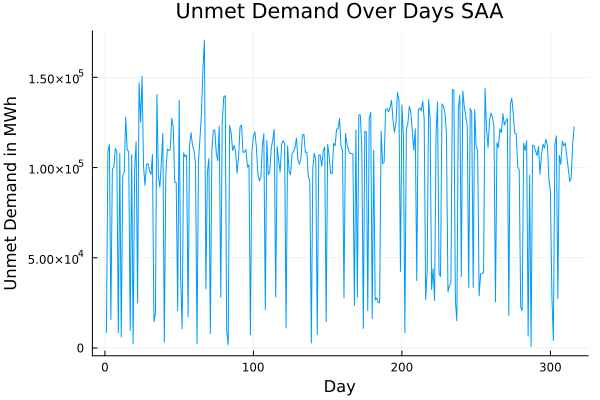

In [50]:
produced = [res.produced for res in SAA_evaluate_results]
not_met_true = [res.not_met_true for res in SAA_evaluate_results]
days = 1:T

# Plot for 'not_met_true'
plot(days, not_met_true, title = "Unmet Demand Over Days SAA", xlabel = "Day", ylabel = "Unmet Demand in MWh", legend = false)

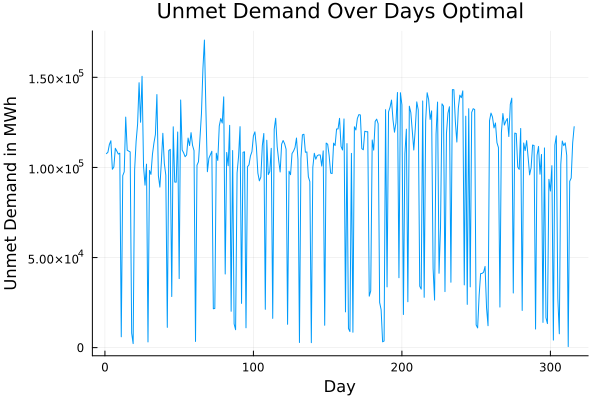

In [51]:
produced = [res.produced for res in Optimal_evaluate_results]
not_met_true = [res.not_met_true for res in Optimal_evaluate_results]
days = 1:T

# Plot for 'not_met_true'
plot(days, not_met_true, title = "Unmet Demand Over Days Optimal", xlabel = "Day", ylabel = "Unmet Demand in MWh", legend = false)

### Dummy model for baseline
Everyday, forecast demand (in this case using average y of the train set). Start producing from the cheapest source (Wind&Solar) until its capacity is saturated or the demand is met. If there's still demand left, move to the next cheapest source (petroleum), and so on.

In [31]:
forecast_demand = [mean(y_train) for t in 1:T];

# Sort production sources by cost (cheapest first)
#sorted_sources = sort(collect(production_cost), by = x -> x[2])

# Function to decide production
function decide_production(forecast_demand, production_capacity, sorted_sources=[3,2,1], T=316)
    production_plan = zeros(I, T)
    for t in 1:T
        remaining_demand = forecast_demand[t]

        for source in sorted_sources
            capacity = P[source]
            production = min(capacity, remaining_demand)
            production_plan[source,t] = production
            remaining_demand -= production
            if remaining_demand <= 0
                break
            end
        end
    end 
    return production_plan
end;

# Get the dummy production plan
dummy_prescriptions = decide_production(y_test, P);

# Report revenue on the test set and emissions 
objective_test_dummy = objective_test(dummy_prescriptions)
objective_emissions_dummy = objective_emissions(dummy_prescriptions)[1]

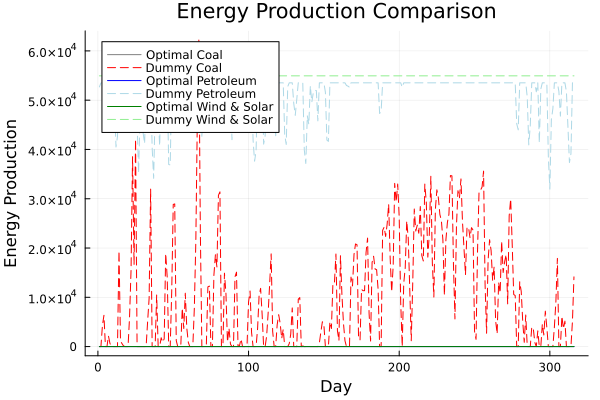

In [32]:
days = 1:T 

# Optimal prescriptions
optimal_coal = optimal_prescriptions[1, :];
optimal_petroleum = optimal_prescriptions[2, :];
optimal_wind_solar = optimal_prescriptions[3, :];

# SAA prescriptions
coal = prescriptions[1, :];
petroleum = prescriptions[2, :];
wind_solar = prescriptions[3, :];

# Baseline prescriptions
dummy_coal = dummy_prescriptions[1, :];
dummy_petroleum = dummy_prescriptions[2, :];
dummy_wind_solar = dummy_prescriptions[3, :];

plot(days, optimal_coal, label = "Optimal Coal", color = :grey)
#plot!(days, coal, label = "SAA Coal", color = :red, linestyle = :dash)
plot!(days, dummy_coal, label = "Dummy Coal", color = :red, linestyle = :dash)

plot!(days, optimal_petroleum, label = "Optimal Petroleum", color = :blue)
#plot!(days, petroleum, label = "SAA Petroleum", color = :lightblue, linestyle = :dash)
plot!(days, dummy_petroleum, label = "Dummy Petroleum", color = :lightblue, linestyle = :dash)

plot!(days, optimal_wind_solar, label = "Optimal Wind & Solar", color = :green)
#plot!(days, wind_solar, label = "SAA Wind & Solar", color = :lightgreen, linestyle = :dash)
plot!(days, dummy_wind_solar, label = "Dummy Wind & Solar", color = :lightgreen, linestyle = :dash)

title!("Energy Production Comparison")
xlabel!("Day")
ylabel!("Energy Production")


## KNN weighted approach

In [33]:
@sk_import neighbors: KNeighborsRegressor

[ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
[ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment
Error while loading conda entry point: conda-libmamba-solver (dlopen(/Users/claraschneuwly/.julia/conda/3/x86_64/lib/python3.10/site-packages/libmambapy/bindings.cpython-310-darwin.so, 0x0002): Library not loaded: '@rpath/libarchive.19.dylib'
  Referenced from: '/Users/claraschneuwly/.julia/conda/3/x86_64/lib/libmamba.2.0.0.dylib'
  Reason: tried: '/Users/claraschneuwly/.julia/conda/3/x86_64/lib/libarchive.19.dylib' (no such file), '/Users/claraschneuwly/.julia/conda/3/x86_64/lib/python3.10/site-packages/libmambapy/../../../libarchive.19.dylib' (no such file), '/Users/claraschneuwly/.julia/conda/3/x86_64/lib/python3.10/site-packages/libmambapy/../../../libarchive.19.dylib' (no such file), '/Users/claraschneuwly/.julia/conda/3/x86_64/bin/../lib/libarchive.19.dylib' (no such file), '/Users/claraschneuwly

Solving environment: ...working... done

# All requested packages already installed.



PyObject <class 'sklearn.neighbors._regression.KNeighborsRegressor'>

In [38]:
# Train KNN classifier and use it to find the k nearest neighbors of each test sample
res = Dict()
k_max = 15

for n_neighbors=1:k_max
    
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn_clf = fit!(knn, Matrix(JuMP.value.(X_train)), y_train)
    
    # Optimization problem 3
    model = Model(Gurobi.Optimizer)
    
    weights_knn = []
    
    for t=1:T
        # Get k nearest neighbors for each row j in test set
        neighbor_distances, neighbor_indices = knn_clf.kneighbors([Matrix(JuMP.value.(X_test))[t, :]], n_neighbors=n_neighbors) 
        
        neighbor_indices = neighbor_indices .+ 1 # bc this is a python package
        
        weighted_sum = sum(y_train[neighbor_indices])/n_neighbors
        
        push!(weights_knn, weighted_sum)
    end

    alpha = 1000

    model = Model(Gurobi.Optimizer);

    @variable(model, z[i=1:I,t=1:T] >= 0)

    @constraint(model, emissions_constraint, sum(sum(z[i,t] * e[i] for i=1:I) for t=1:T) <= E)
    @constraint(model, production_constraint[i=1:I, t=1:T], z[i,t] <=  P[i])

    #@objective(model, Min, sum(sum(z[i,t] * c[i] for i=1:I) - s[t] * y[t] + alpha * max(0, sum(y[t] - z[i,t] for i=1:I)) for t=1:T)) 

    # Auxiliary variable for modeling max operator in objective function
    @variable(model, u[t=1:T] >= 0) 
    for t in 1:T
        @constraint(model, u[t] >=  weights_knn[t] - sum(z[i, t] for i=1:I))
        @constraint(model, u[t] >= 0)
    end
    @objective(model, Min, sum(sum(z[i, t] * (c[i] - s) for i=1:I) + alpha * u[t] for t=1:T));
    
    set_optimizer_attribute(model, "TimeLimit", 60.0);
    optimize!(model);
    
    # Get prescriptions on the test set
    prescriptions = JuMP.value.(z)
    # Report revenue on the test set and emissions 
    objective = JuMP.objective_value(model);
    objective_test = 0.0
    objective_emissions = 0.0
    for t=1:T
        energy_produced = 0.0
        for i=1:I
            objective_test += prescriptions[i,t] * (c[i] - s)
            energy_produced += prescriptions[i,t]
            objective_emissions += prescriptions[i,t] * e[i]
        end
        objective_test -= max(0, y_test[t]-energy_produced)
    end 

    res[n_neighbors] = [prescriptions, objective_test, objective_emissions]
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 60
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2213 rows, 1896 columns and 5372 nonzeros
Model fingerprint: 0x70856267
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [2e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 7e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1896 rows and 0 columns
Presolve time: 0.00s
Presolved: 317 rows, 1896 columns, 3476 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.62

In [43]:
for i=1:k_max
    prescriptions, objective_test, objective_emissions = res[i][1],res[i][2],res[i][3]
    println("k = $i: Cost on the test set: \$$objective_test")
    println("Emissions: $objective_emissions kg CO2\n")
end

k = 1: Cost on the test set: $-1.659353976824658e9
Emissions: 7.375353424657535e10 kg CO2

k = 2: Cost on the test set: $-1.6593539768246582e9
Emissions: 7.375353424657535e10 kg CO2

k = 3: Cost on the test set: $-1.659353976824658e9
Emissions: 7.375353424657535e10 kg CO2

k = 4: Cost on the test set: $-1.6593539768246582e9
Emissions: 7.375353424657535e10 kg CO2

k = 5: Cost on the test set: $-1.6593561317046583e9
Emissions: 7.375353424657535e10 kg CO2

k = 6: Cost on the test set: $-1.6593539768246582e9
Emissions: 7.375353424657535e10 kg CO2

k = 7: Cost on the test set: $-1.6593539768246582e9
Emissions: 7.375353424657535e10 kg CO2

k = 8: Cost on the test set: $-1.6593539768246584e9
Emissions: 7.375353424657535e10 kg CO2

k = 9: Cost on the test set: $-1.6593539768246584e9
Emissions: 7.375353424657535e10 kg CO2

k = 10: Cost on the test set: $-1.6593539768246582e9
Emissions: 7.375353424657535e10 kg CO2

k = 11: Cost on the test set: $-1.6593540172646582e9
Emissions: 7.375353424657535